In [ ]:
import pandas as pd
import numpy as np

# MATRIZ DE TRANSICIÓN DE ESTADOS PARA EL ENGAGEMENT

df = pd.read_csv("/Users/joshchaidez/Desktop/Globant_Motivation_Prediction/data/data_globant.csv")

# Discretizar el engagement
bins = np.arange(0, 5.1, 0.5)
labels = np.arange(0.5, 5.1, 0.5)

df["Engagement_bin"] = pd.cut(df["Engagement"], bins=bins, labels=labels, include_lowest=True)

df = df.sort_values(by=["Name", "Month", "Day"])

transition_counts = pd.DataFrame(
    0,
    index=labels,
    columns=labels,
    dtype=int
)

for name, group in df.groupby("Name"):
    states = group["Engagement_bin"].dropna().astype(float).values
    
    for (s1, s2) in zip(states[:-1], states[1:]):
        transition_counts.loc[s1, s2] += 1

transition_prob = transition_counts.div(transition_counts.sum(axis=1).replace(0, np.nan), axis=0)

# Eliminar valores menores a un treshold en la matriz de conteos
threshold2 = 5
transition_counts = transition_counts.where(transition_counts >= threshold2, 0)

# Eliminar probabilidades menores a un umbral en la matriz de probabilidades y normalizar
threshold = 0.05
transition_prob = transition_prob.where(transition_prob >= threshold, 0)

# Normalizar nuevamente
transition_prob = transition_prob.div(transition_prob.sum(axis=1).replace(0, np.nan), axis=0)

transition_counts, transition_prob

(     0.5  1.0  1.5  2.0  2.5   3.0   3.5  4.0  4.5  5.0
 0.5  190    0    0   32   77    73    53   57   17    0
 1.0    0   68    0    0    0    50     6   15    6    0
 1.5    0    0    6    0    0     0     0    0    0    0
 2.0   34    0    0  308   87    38    10    5    0    0
 2.5   66    0    0   96  960   293   115   42   16    0
 3.0   71   53    0   41  304  1392   640  130    6    5
 3.5   68    8    0    8  114   685  1171  509   74    0
 4.0   59   11    0    0   37   115   551  768  230   35
 4.5   19    6    0    0   11     6    77  245  383   63
 5.0    0    5    0    0    0     0     6   31   68  504,
           0.5       1.0  1.5       2.0       2.5       3.0       3.5  \
 0.5  0.394191  0.000000  0.0  0.066390  0.159751  0.151452  0.109959   
 1.0  0.000000  0.511278  0.0  0.000000  0.000000  0.375940  0.000000   
 1.5  0.000000  0.000000  0.4  0.000000  0.000000  0.000000  0.133333   
 2.0  0.072805  0.000000  0.0  0.659529  0.186296  0.081370  0.000000   
 2.5  0

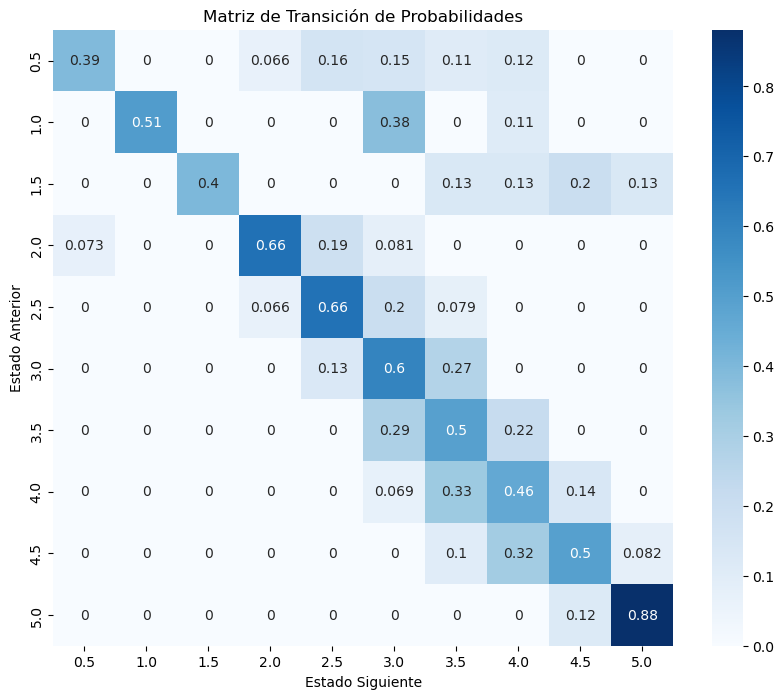

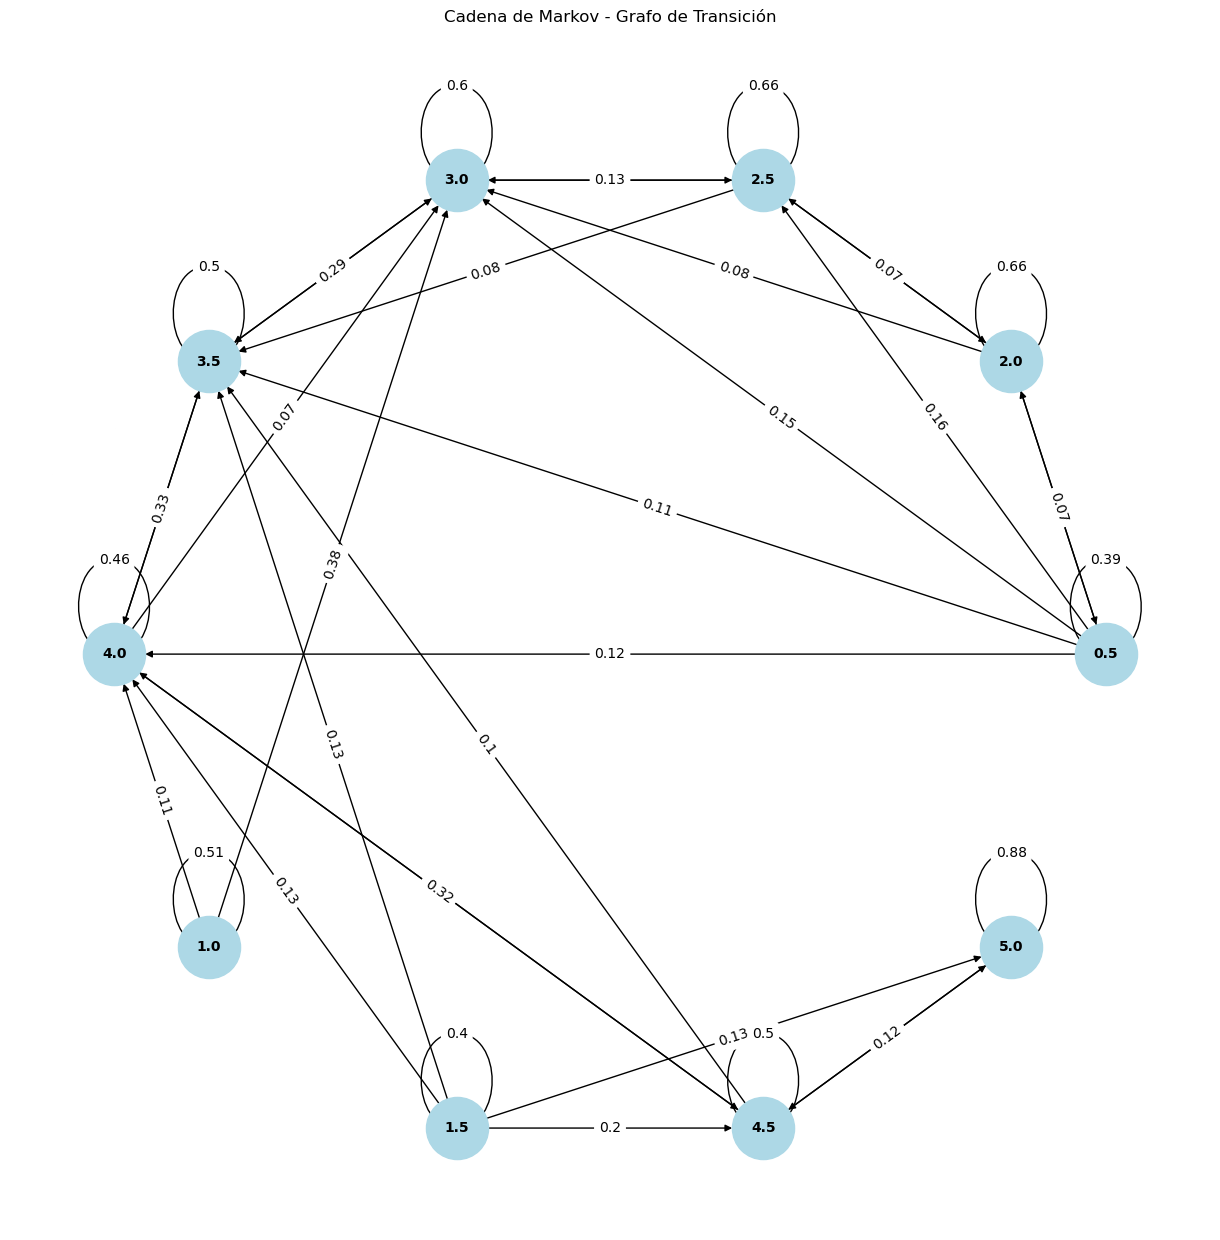

In [36]:
# Dibujar la matriz de transición de probabilidades
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(transition_prob, annot=True, cmap="Blues", cbar=True)
plt.title("Matriz de Transición de Probabilidades")
plt.xlabel("Estado Siguiente")
plt.ylabel("Estado Anterior")
plt.show()

# Dibujar la cadena de Markov como un grafo usando networkx redondeando probabilidades a 2 decimales colocando los nodos en circulo en orden ascendente respecto a el valor del estado
import networkx as nx

G = nx.DiGraph()

# Añadir nodos y aristas
for i in transition_prob.index:
    for j in transition_prob.columns:
        if transition_prob.loc[i, j] > 0:
            G.add_edge(i, j, weight=round(transition_prob.loc[i, j], 2))

# Dibujar el grafo
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Cadena de Markov - Grafo de Transición")
plt.show()


In [41]:
import pandas as pd
import numpy as np

# ===============================
# 1. Cargar dataset
# ===============================
df = pd.read_csv("/Users/joshchaidez/Desktop/Globant_Motivation_Prediction/data/data_globant.csv")

# ===============================
# 2. Discretizar el engagement (si no existe ya)
# ===============================
bins = np.arange(0.25, 5.26, 0.5)   # [0.25, 0.75, 1.25, ..., 4.75, 5.25]
labels = np.arange(0.5, 5.1, 0.5)   # 0.5, 1.0, ..., 5.0

if "Engagement_bin" not in df.columns:
    df["Engagement_bin"] = pd.cut(
        df["Engagement"],
        bins=bins,
        labels=labels,
        include_lowest=True
    )

# Asegurar orden temporal
df = df.sort_values(by=["Name", "Month", "Day"])


# ===============================
# 3. Función para cadena de orden n
# ===============================
def compute_nth_order_markov(df, order_n=2, state_col="Engagement_bin",
                             sort_keys=("Name", "Month", "Day"),
                             possible_states=None):
    """
    Calcula la matriz de transición de una cadena de Markov de orden n.
    
    - df: DataFrame con la columna de estados discretos.
    - order_n: orden de la cadena (n).
    - state_col: nombre de la columna de estados discretos.
    - sort_keys: columnas para ordenar dentro de cada persona / serie.
    - possible_states: lista/array de estados posibles (para columnas).
                      Si es None, se infiere de los datos.
    
    Devuelve:
    - counts: matriz de conteos (index = tupla de n estados, columns = estado siguiente)
    - probs:  matriz de probabilidades
    """
    
    # Ordenar por keys de tiempo/persona
    df_sorted = df.sort_values(list(sort_keys)).copy()
    
    # Si no se dan los estados posibles, inferirlos
    if possible_states is None:
        possible_states = sorted(df_sorted[state_col].dropna().unique())
    
    # Construir lista de transiciones
    records = []  # cada elemento: (prev_tuple, next_state)
    
    for name, group in df_sorted.groupby("Name"):
        states = group[state_col].dropna().astype(float).values
        
        if len(states) <= order_n:
            continue
        
        # Ventanas deslizantes de tamaño n -> siguiente estado
        for i in range(len(states) - order_n):
            prev_n = tuple(states[i:i+order_n])
            next_state = states[i + order_n]
            records.append((prev_n, next_state))
    
    if not records:
        raise ValueError("No hay suficientes datos para el orden especificado.")
    
    seq_df = pd.DataFrame(records, columns=["prev", "next"])
    
    # Conteos: index = tupla de n estados, columnas = estado siguiente
    counts = seq_df.groupby(["prev", "next"]).size().unstack(fill_value=0)
    
    # Asegurar que todas las columnas de estados posibles estén presentes
    for s in possible_states:
        if s not in counts.columns:
            counts[s] = 0
    
    # Reordenar columnas según posibles_states
    counts = counts[possible_states]
    
    # Matriz de probabilidades (normalizando por filas)
    probs = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0)
    
    return counts, probs


# ===============================
# 4. Ejemplo: cadena de orden 2
# ===============================
transition_counts_n2, transition_probs_n2 = compute_nth_order_markov(
    df,
    order_n=2,
    state_col="Engagement_bin",
    sort_keys=("Name", "Month", "Day"),
    possible_states=labels  # 0.5, 1.0, ..., 5.0
)

# transition_counts_n2 -> matriz de conteos para orden 2
# transition_probs_n2  -> matriz de probabilidades para orden 2

transition_probs_n2
transition_counts_n2


next,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
prev,,,,,,,,,,
"(0.5, 0.5)",47,0,0,0,13,13,16,14,3,0
"(0.5, 2.5)",5,0,0,0,26,6,5,2,2,0
"(0.5, 3.0)",0,0,0,0,7,3,5,0,0,0
"(0.5, 3.5)",0,0,0,0,2,3,10,6,1,0
"(0.5, 4.0)",0,0,0,0,1,0,8,12,1,0
...,...,...,...,...,...,...,...,...,...,...
"(5.0, 3.0)",0,0,0,0,0,3,0,0,0,0
"(5.0, 3.5)",0,0,0,0,3,0,0,0,1,2
"(5.0, 4.0)",0,0,0,0,0,0,1,2,5,0
